In [2]:
%cd /Volumes/Samsung_T5/ProtPredict/scripts

/Volumes/Samsung_T5/ProtPredict/scripts


## Load dependencies

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate, KFold
from xgboost.sklearn import XGBRegressor
from other import Bayes_CV, return_protein_dataset, extract_shap_return_absmeans, extract_xgb_feature_values
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

## Define initial parameters
Define initial parameters, such as number of workers, cross-validation setup and which protein to use for model optimization.

In [4]:
n_parallel = 60 # If parallel, define n workers

# define the K in the cross-validation strategies
cvcount_inner = 5 # K-fold for optimization
cvcount_outer = 5 # K-fold for evaluation

opt_protein = 'A5Z2X5' #protein to optimize the models on

## Load the data-sets

Load the needed data-sets.
Data-sets from Messner et al. (https://www.biorxiv.org/content/10.1101/2022.05.17.492318v1) and Mülleder et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5055083/)

Data-sets need to be downloaded separately.

In [5]:
proteomics_dataset_path = '../data/proteomics_messner.csv' #not included in the the repo
functional_metabolomics_path = '../data/functional_metabolomics_mulleder.xls' #not included in the repo

# load the proteomics dataset from Messner et al. (2022)
proteomic_dataset = pd.read_csv('../data/proteomics_messner.csv')
proteomic_dataset = proteomic_dataset.groupby('Unnamed: 0').mean() #Average potential duplicate rows

# load the functional metabolomics dataset from Mulleder et al. (2016)
aaDataset = pd.read_excel('../data/functional_metabolomics_mulleder.xls',sheet_name = 'intracellular_concentration_mM')
aaDataset.index = aaDataset['ORF']
aaDataset = aaDataset.iloc[:,2:21] #limit to the measured amino acid concentrations

# merge the two on the ORF of the deletion
dataset = pd.merge(proteomic_dataset, aaDataset, left_index=True, right_index=True)


## Model optimization

Optimize/tune hyperparameters for XGBoost using bayesian optimization. In the study, the model is being tuned on the first example in the data-set (Uniprot: A5Z2X5, Common: MIN8, ORF: YPR010C-A)

In [ ]:
# define parameter space to search
params={'gamma': (0.0,1.0),
        'max_depth': (2, 12),
        'subsample': (0.4, 1.0),
        'learning_rate':(0.005,0.3,'log-uniform'),
        'n_estimators':(10,1000),
        'colsample_bytree':(0.4, 1.0),
        'reg_lambda':(0.0,1.0),
        'reg_alpha':(0.0,0.5)}

# function to define X and Y
X, y, nancount = return_protein_dataset(dataset, opt_protein)

# start the bayesian optimization process. This will take some time!
best_params = Bayes_CV(params, X, y, cvcount_inner, n_parallel, 42)

## Train the models

Train the models for all of the separate proteins using XGBoost and evaluate with 5-fold CV and save them for later use. 

In [ ]:
scores = pd.DataFrame(columns = ['Protein','MissingY','R-squared','RMSE'])
for Protein in dataset.columns[:2292]:
    
    X, y, nancount = return_protein_dataset(dataset, Protein)
    
    # define regressor and evaluate model
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    outer_cv = KFold(n_splits=cvcount_outer, shuffle=True, random_state=0)
    score_all = cross_validate(regressor, X, np.ravel(y), cv=outer_cv, scoring = ('r2', 'neg_root_mean_squared_error'))
    score = score_all['test_r2']
    rmse = score_all['test_neg_root_mean_squared_error']

    # save scores
    temp_df = pd.DataFrame([[Protein, nancount,score[0],rmse[0]], [Protein, nancount,score[1],rmse[1]], [Protein, nancount,score[2],rmse[2]], 
            [Protein, nancount,score[3],rmse[3]], [Protein, nancount,score[4],rmse[4]]], columns=['Protein', 'MissingY', 'R-squared', 'RMSE'])
    scores = scores.append(temp_df)
    scores.to_csv('../results/evaluation/AA/protfromAA_results.csv')

## Visualize performance metrics

Visualize average cross-validation performance (in R2) across the space of available proteins in the data-set.

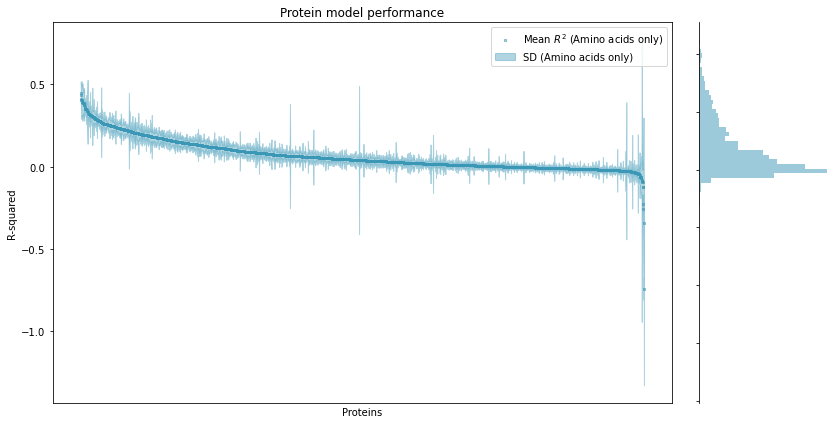

In [8]:
#data = pd.read_csv('../results/evaluation/AA/protfromAA_results.csv', index_col = 0)
data = pd.read_csv('../results/evaluation/AA/AA_20230314.csv', index_col = 0) # this to read the already existing results
data_mean = data.groupby(by='Protein').mean() # group and take the average of folds
data_mean = data_mean.sort_values(by = 'R-squared', ascending = False) # sort by average

#calculate SD?
data_sd = pd.DataFrame(data.groupby(by='Protein').std()['R-squared'])
data_sd.columns = ['SD']


#sort by average?
data_mean = data_mean.sort_values(by = 'R-squared', ascending = False)

#merge with sd
data_mean = pd.merge(data_mean, data_sd, left_index = True, right_index = True, how = 'left')


fig = plt.figure(figsize = (14,7))
gs = GridSpec(4,5)

ax_joint = fig.add_subplot(gs[0:4,0:4])
ax_marg_y = fig.add_subplot(gs[0:4,4])
ax_joint.scatter(x = data_mean.index,y = data_mean['R-squared'], alpha = 0.5, marker = 's', s = 7, label='ILP', color = '#3B97B6')
ax_joint.fill_between(data_mean.index, data_mean['R-squared'] - data_mean['SD'], data_mean['R-squared'] + data_mean['SD'], color='#3B97B6', alpha=0.4,
                      label = 'Standard deviation')
ax_marg_y.hist(data_mean['R-squared'],orientation="horizontal", bins = 75, alpha = 0.5, density = True, color = '#3B97B6')

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Proteins')
ax_joint.set_ylabel('R-squared')

ax_marg_y.spines['top'].set_visible(False)
ax_marg_y.spines['right'].set_visible(False)
ax_marg_y.spines['bottom'].set_visible(False)

ax_joint.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_marg_y.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

ax_joint.legend(['Mean $R^2$ (Amino acids only)','SD (Amino acids only)'])
ax_joint.set_title('Protein model performance')
plt.show()

## Extract SHAP-values

Extract SHAP-values to be used for later analysis.

In [ ]:
shapmeans_proteins = pd.DataFrame(index = dataset.columns[2292:]) #predefine df for feature shap-values
for Protein in dataset.columns[:2292]:    
    X, y, nancount = return_protein_dataset(dataset, Protein)
    
    #train regressor
    regressor = XGBRegressor(random_state = 0, n_jobs = n_parallel, **best_params)
    regressor.fit(X,y)
    
    #extract shap-values (in the form of abs(average)) for all proteins in the dataset
    shapmeans_proteins = extract_shap_return_absmeans(regressor, X, Protein, shapmeans_proteins)
    shapmeans_proteins.to_csv('../intermediateData/feature_values/AA/Proteins_AA_SHAP_means.tsv', sep = '\t')
    
    #extract all XGB-feature values (gain, total gain, ...) and save protein result each separately
    xgb_feature_values = extract_xgb_feature_values(regressor)
    xgb_feature_values.to_csv('../intermediateData/feature_values/AA/'+Protein+'_AA_XGB.tsv', sep = '\t')